## Imports and stuff

In [1]:
import os
import warnings
import argparse
import pandas as pd
import numpy as np
from scipy import stats
from keras.activations import elu, selu, relu, softplus
from keras.losses import mean_squared_error, mean_absolute_error, mean_squared_logarithmic_error, logcosh
from keras.initializers import RandomNormal, glorot_uniform, glorot_normal, VarianceScaling, TruncatedNormal, lecun_normal, he_uniform
from sklearn.externals import joblib
from manage import ManagementSystem
from prep import DataPrep
from loader import DataLoader
from analysis import DataAnalysis
from model import DL, BestModelKCross, ModelKCross, randomString
from MLA import MLA
from sklearn import linear_model, neighbors, svm, metrics, ensemble, decomposition, preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## Loading data

In [2]:
datadir = '../data'
filenames = ['../data/raspdeep_bigger.txt']
ext_test_dir = "../../external_test/"
all_dataset_names={'BACE_Protein_Ligand_Parameter' : 'BACE',
       'CDK2-CyclinA_Protein_Ligand_Parameter': 'CDK2-Cyclin A',
       'CDK2-Kinase_Protein_Ligand_Parameter': 'CDK2 Kinase',
       'CDK2_Protein_Ligand_Parameter': 'CDK2',
       'CHK1-Kinase_Protein_Ligand_Parameter': 'CHK1 Kinase',
       'ERK2_Protein_Ligand_Parameter': 'ERK2', 
                   'HSP90_Protein_Ligand_Parameter': 'HSP90',
       'LpxC_Protein_Ligand_Parameter': 'LpxC', 
                   'Mcl-1_Protein_Ligand_Parameter': 'Mcl-1',
       'Mcl-all_Protein_Ligand_Parameter': 'Mcl-1 all', 
                   'P38_Protein_Ligand_Parameter': 'p38',
       'PTP1B_Protein_Ligand_Parameter': "PTP1B", 
                   'Parameter_HiQ_Set1_55complexes': "CSAR HiQ 1",
       'Parameter_HiQ_Set2_47complexes': "CSAR HiQ 2", 
                   'SYK_Protein_Ligand_Parameter': "SYK",
       'TYK2_Protein_Ligand_Parameter': "TYK2",
       'TYK2_all_Protein_Ligand_Parameter': "TYK2 all",
       'Thrombin_Protein_Ligand_Parameter': "Thrombin",
       'TrmD_Protein_Ligand_Parameter': "TrmD",
       'Urokinase_Protein_Ligand_Parameter': "Urokinase"}

feature_renamer = {'P': 'logP', 'Volume': 'PVol', 'PP(Arom)': 'PlogP(Arom)', 'PP(Non-Arom)': 'PlogP(Non-Arom)'}
ligand_order = ['A', 'D', 'logP', 'W', 'MR', 'MASS']
protein_order = ['PA(D+E)',
                 'PA(N+Q+T+S+DH+EH)',
                 'PA(Y+H)',
                 'PD(K+R+HIP)',
                 'PD(LYN+N+Q)',
                 'PD(T+S+Y+DH+EH)',
                 'PD(W+H)',
                 'PA(Amide-O)',
                 'PD(Amide-NH)',
                 'PlogP(Arom)',
                 'PlogP(Non-Arom)',
                 'PMR(Arom)',
                 'PMR(Non-Arom)',
                 'PVol']
feature_order = protein_order + ligand_order

relevant_grps = ["PDBBIND", "CSAR HiQ", "Wang", "D3R"]

In [3]:
sorted(['PD(K+R+HIP)',
                         'PA(D+E)',
                         'PD(T+S+Y+DH+EH)',
                         'PA(N+Q+T+S+DH+EH)',
                         'PD(LYN+N+Q)',
                         'PD(W+H)',
                         'PA(Y+H)',
                         'PD(Amide-NH)',
                         'PA(Amide-O)',
                         'PlogP(Non-Arom)',
                         'PlogP(Arom)',
                         'PMR(Non-Arom)',
                         'PMR(Arom)',
                         'PVol'], key=lambda x: x.lower())

['PA(Amide-O)',
 'PA(D+E)',
 'PA(N+Q+T+S+DH+EH)',
 'PA(Y+H)',
 'PD(Amide-NH)',
 'PD(K+R+HIP)',
 'PD(LYN+N+Q)',
 'PD(T+S+Y+DH+EH)',
 'PD(W+H)',
 'PlogP(Arom)',
 'PlogP(Non-Arom)',
 'PMR(Arom)',
 'PMR(Non-Arom)',
 'PVol']

In [4]:
style_base = {"savefig.dpi": 600,
              "savefig.bbox": "standard",
         "figure.autolayout": True,
         "font.style": "normal",
         "font.size": 8,
         "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 2,
          "lines.linewidth": 2,
  "legend.frameon": "False",
              "xtick.labelsize": 6,
              "ytick.labelsize": 6,
  "xtick.direction": "out",
  "xtick.major.size": 4,
  "xtick.major.width": 1,
  "xtick.minor.size": 1,
  "xtick.minor.width": 1,
  "ytick.direction": "out",
  "ytick.major.size": 4,
  "ytick.major.width": 1,
  "ytick.minor.size": 1,
  "ytick.minor.width": 1}



In [5]:
filenames.extend([ext_test_dir + name + ".txt" for name in all_dataset_names])
management_system = ManagementSystem(datadir=datadir, make_unique=False)
wdir, logger = management_system.setting()




Start logger

Start generating folder

Setting basic configuration for logger to:  ../data/logfile.log level:  20

get current setting


In [6]:
data_loader = DataLoader(datadir, filenames, logger, to_shuffle=False)
raw_data_all = data_loader.retrieve_data()
raw_data = raw_data_all[filenames[0]]

In [7]:
raw_data.rename(columns=feature_renamer, inplace=True)

In [8]:
raw_data.shape

(3925, 24)

In [9]:
raw_data.head()

,PD(K+R+HIP),PA(D+E),PD(T+S+Y+DH+EH),PA(N+Q+T+S+DH+EH),PD(LYN+N+Q),PD(W+H),PA(Y+H),PD(Amide-NH),PA(Amide-O),PlogP(Non-Arom),...,D,A,logP,MR,W,rot_bonds,MASS,Expt_BE,Atom Efficiency,No. of atoms
PDBID,,,,,,,,,,,,,,,,,,,,,
2r58,1.038,0.346,0.000,0.173,0.519,0.173,0.000,1.038,0.692,0.0,...,4.0,2.0,-3.338,43.212,229.951,0.727,175.0,-2.73,-0.23,12.0
3c2f,3.048,1.143,0.762,0.762,0.191,0.000,0.000,1.143,0.762,0.0,...,2.0,14.0,-5.600,61.969,639.669,0.045,385.0,-2.72,-0.12,22.0
3g2y,1.157,0.386,1.350,1.736,1.157,0.000,0.193,1.350,1.736,0.0,...,2.0,6.0,-0.265,47.790,223.277,0.067,194.0,-2.73,-0.19,14.0
4qsu,0.000,0.000,0.000,0.292,0.585,0.000,0.292,1.754,0.292,0.0,...,1.0,4.0,-0.057,31.195,64.310,0.000,126.0,-2.73,-0.30,9.0
4qsv,0.000,0.412,0.000,0.206,0.412,0.000,0.412,3.501,1.030,0.0,...,3.0,7.0,-1.090,55.505,411.954,0.000,242.0,-2.73,-0.16,17.0


### external test sets

In [10]:
all_ys = {}
for fname, df in raw_data_all.items():
    name = ""
    for key, translation in all_dataset_names.items():
        if key in fname:
            name = translation
            break
    else:
        print(fname)
        name = "PDBBIND"
        
    all_ys[name] = df.rename(columns=feature_renamer)

../data/raspdeep_bigger.txt


In [11]:
all_y_dists = pd.concat(all_ys, names=["DS"]).reset_index()


## Exploration

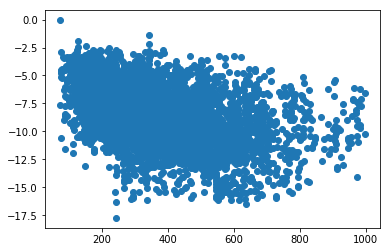

In [12]:
plt.scatter(all_y_dists.MASS, all_y_dists.Expt_BE)

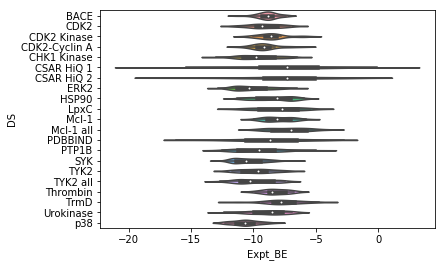

In [13]:
sns.violinplot(data=all_y_dists, y="DS", x="Expt_BE")


In [14]:
dataset_sets = {
    "CSAR12":("CDK2-Cyclin A", "CDK2 Kinase", "CHK1 Kinase", "ERK2", "LpxC", "Urokinase"),
    "CSAR14":("SYK", "TrmD", "HSP90"),
    "CSAR HiQ": ("CSAR HiQ 1", "CSAR HiQ 2"),
    "Wang":("BACE", "CDK2", "Mcl-1 all", "p38", "PTP1B", "Thrombin", "TYK2 all"),
    "D3R":("CDK2-Cyclin A", "CDK2 Kinase", "CHK1 Kinase", "ERK2", "LpxC", "Urokinase","SYK", "TrmD", "HSP90"),
    "PDBBIND": ("PDBBIND",),
}

grouped_ys = {}
for ky, ve in dataset_sets.items():
    grouped_ys[ky] = []
    for e in ve:
        grouped_ys[ky].append(all_ys[e])
    grouped_ys[ky] = pd.concat(grouped_ys[ky])

grouped_y_dists = pd.concat(grouped_ys, names=["DS"]).reset_index()
    

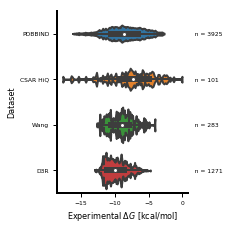

In [15]:
with plt.style.context(style_base):
    ax = sns.violinplot(data=grouped_y_dists, y="DS", x="Expt_BE", bw=.02, cut=0, order=relevant_grps)
    fig = ax.get_figure()
    ax.set_xlabel("Experimental $\Delta G$ [kcal/mol]")
    ax.set_ylabel("Dataset")
    opp_ax = ax.twinx()
    opp_ax.set_yticks(ax.get_yticks())
    opp_ax.set_ylim(ax.get_ylim())

    n_in_grps = grouped_y_dists.groupby("DS").count()["PDBID"]
    n_in_grps = ["  n = " + str(n_in_grps[grp_name]) for grp_name in relevant_grps]
    opp_ax.set_yticklabels(n_in_grps)

    opp_ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.tight_layout()
    fig.set_size_inches((3.3,3.3))
    fig.savefig(os.path.join(datadir, "plots", "violinplot_deltaG.svg"))
    fig.savefig(os.path.join(datadir, "plots", "violinplot_deltaG.png"))

    #

In [16]:
grouped_y_dists.groupby("DS").count()["PDBID"]

DS
CSAR HiQ     101
CSAR12       511
CSAR14       760
D3R         1271
PDBBIND     3925
Wang         283
Name: PDBID, dtype: int64

In [17]:
grouped_data_tidy = grouped_y_dists.melt(id_vars=["PDBID","DS"])

In [18]:
cols = [*grouped_y_dists.columns]
cols

['DS',
 'PDBID',
 'PD(K+R+HIP)',
 'PA(D+E)',
 'PD(T+S+Y+DH+EH)',
 'PA(N+Q+T+S+DH+EH)',
 'PD(LYN+N+Q)',
 'PD(W+H)',
 'PA(Y+H)',
 'PD(Amide-NH)',
 'PA(Amide-O)',
 'PlogP(Non-Arom)',
 'PlogP(Arom)',
 'PMR(Non-Arom)',
 'PMR(Arom)',
 'PVol',
 'D',
 'A',
 'logP',
 'MR',
 'W',
 'rot_bonds',
 'MASS',
 'Expt_BE',
 'Atom Efficiency',
 'No. of atoms']

## Correlation plotting

In [19]:
raw_data.shape

(3925, 24)

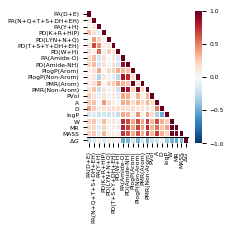

In [20]:
#data_for_corr = raw_data.drop(columns=["Atom Efficiency", "No. of atoms", "rot_bonds"])
data_for_corr = raw_data[feature_order + ['Expt_BE']]
with plt.style.context(style_base):
    corrmat = data_for_corr.corr(method='spearman')
    f, ax = plt.subplots(figsize=(12, 10))
    mask = np.triu(np.ones(corrmat.shape), k=1)
    locator = matplotlib.ticker.MultipleLocator(0.5)
    sns.heatmap(corrmat.rename(columns={"Expt_BE":"$\Delta G$"}, index={"Expt_BE":"$\Delta G$"}),
                mask=mask, ax=ax, cmap="RdBu_r", vmin=-1., vmax=1., cbar_kws={'ticks': locator},
                linewidths=0.1, center=0)
    ax.axhline(corrmat.shape[0]-1, 0, corrmat.shape[0]-1, color="black", lw=1)
    plt.gcf().set_size_inches((3.3, 3.3))
    plt.savefig(os.path.join(datadir, "plots", "correlation_matrix.png"))
    plt.savefig(os.path.join(datadir, "plots", "correlation_matrix.svg"))

In [21]:
corrmat.drop(columns="Expt_BE", index="Expt_BE").stack().sort_values().iloc[:-20].tail(40)

PA(N+Q+T+S+DH+EH)  PD(T+S+Y+DH+EH)      0.661489
PD(T+S+Y+DH+EH)    PA(N+Q+T+S+DH+EH)    0.661489
MR                 PD(Amide-NH)         0.676197
PD(Amide-NH)       MR                   0.676197
MASS               PMR(Non-Arom)        0.678381
PMR(Non-Arom)      MASS                 0.678381
PlogP(Non-Arom)    MR                   0.684827
MR                 PlogP(Non-Arom)      0.684827
W                  PMR(Non-Arom)        0.697250
PMR(Non-Arom)      W                    0.697250
A                  MASS                 0.708076
MASS               A                    0.708076
                   PA(Amide-O)          0.712494
PA(Amide-O)        MASS                 0.712494
PMR(Non-Arom)      MR                   0.728854
MR                 PMR(Non-Arom)        0.728854
W                  PA(Amide-O)          0.739866
PA(Amide-O)        W                    0.739866
PlogP(Non-Arom)    PD(Amide-NH)         0.746337
PD(Amide-NH)       PlogP(Non-Arom)      0.746337
MR                 P

In [22]:
corrmat["Expt_BE"].to_frame()

,Expt_BE
PA(D+E),-0.239672
PA(N+Q+T+S+DH+EH),-0.149534
PA(Y+H),0.060543
PD(K+R+HIP),-0.120281
PD(LYN+N+Q),0.059729
PD(T+S+Y+DH+EH),-0.087470
PD(W+H),0.052504
PA(Amide-O),-0.489766
PD(Amide-NH),-0.447092
PlogP(Arom),-0.190099


In [23]:
print(corrmat["Expt_BE"].to_frame().drop(index='Expt_BE').to_latex(float_format="{:.3f}".format))

\begin{tabular}{lr}
\toprule
{} &  Expt\_BE \\
\midrule
PA(D+E)           &   -0.240 \\
PA(N+Q+T+S+DH+EH) &   -0.150 \\
PA(Y+H)           &    0.061 \\
PD(K+R+HIP)       &   -0.120 \\
PD(LYN+N+Q)       &    0.060 \\
PD(T+S+Y+DH+EH)   &   -0.087 \\
PD(W+H)           &    0.053 \\
PA(Amide-O)       &   -0.490 \\
PD(Amide-NH)      &   -0.447 \\
PlogP(Arom)       &   -0.190 \\
PlogP(Non-Arom)   &   -0.450 \\
PMR(Arom)         &   -0.187 \\
PMR(Non-Arom)     &   -0.460 \\
PVol              &   -0.224 \\
A                 &   -0.187 \\
D                 &   -0.091 \\
logP              &   -0.364 \\
W                 &   -0.474 \\
MR                &   -0.508 \\
MASS              &   -0.454 \\
\bottomrule
\end{tabular}



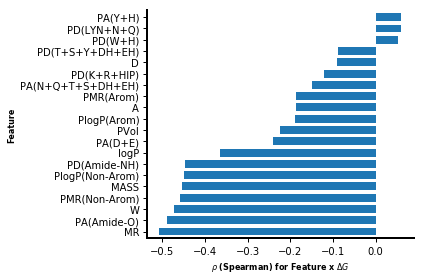

In [24]:
with plt.style.context(style_base):
    corrmat["Expt_BE"].to_frame().drop("Expt_BE").sort_values(by="Expt_BE").plot.barh(legend=False, grid=False, fontsize=10, width=0.7)
    plt.xlabel(r"$\rho $ (Spearman) for Feature x $\Delta G$", fontweight="bold")
    plt.ylabel("Feature", fontweight="bold")
    plt.tight_layout()
    plt.savefig(os.path.join(datadir, "plots", "correlation_feature_vs_BE.png"),)
    plt.savefig(os.path.join(datadir, "plots", "correlation_feature_vs_BE.svg"),)

## Distributions, all features

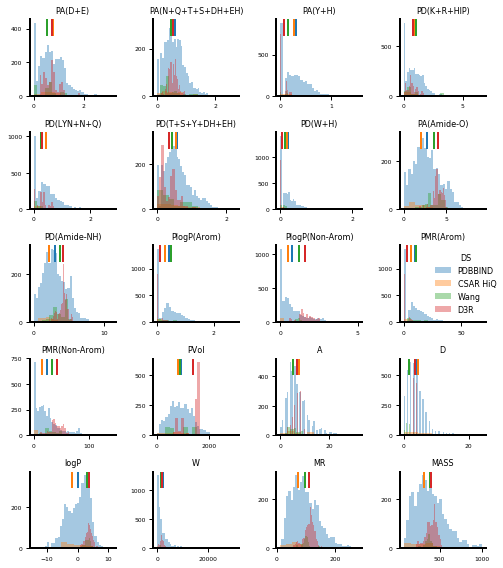

In [25]:
filtered_grouped_data = grouped_data_tidy.query("variable not in ['rot_bonds', 'Expt_BE', 'Atom Efficiency', 'No. of atoms']")
with plt.style.context(style_base):
    g = sns.FacetGrid(data=filtered_grouped_data, col="variable", hue="DS",
                      sharex=False, sharey=False, 
                      col_wrap=4, col_order=feature_order, 
                      hue_order=relevant_grps)
    g.map(sns.distplot, "value", kde=False, )
    def plot_median(x, *args, **kwargs):
        median = x.mean()
        plt.gca().axvline(median, ymin=0.8, ymax=1, **kwargs)
    g.map(plot_median, "value")
    g.set_titles("{col_name}").set_xlabels("")
    g.add_legend()
    plt.gcf().set_size_inches((7,8))
    plt.savefig(os.path.join(datadir, "plots", "dataset_feature_dist.png"))
    plt.savefig(os.path.join(datadir, "plots", "dataset_feature_dist.svg"))    

## PCA exploration

In [26]:
grouped_features = grouped_y_dists.iloc[:,2:-3].values
train_features = grouped_y_dists.query("DS == 'PDBBIND'").iloc[:,2:-3].values
scaler = preprocessing.StandardScaler()
train_features = scaler.fit_transform(train_features)

grouped_features = scaler.transform(grouped_features)

In [27]:
n_PCs = 8
pca = decomposition.PCA(n_components=n_PCs)

In [28]:
pca.fit(train_features)
pca_results = pca.transform(grouped_features)

In [29]:
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

[0.31960046 0.16423513 0.09898518 0.07273214 0.05607751 0.04914839
 0.04310485 0.04043236] 0.8443160221614621


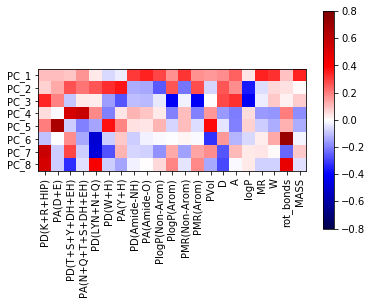

In [30]:
plt.imshow(pca.components_, cmap="seismic", vmax=0.8, vmin=-0.8)
plt.yticks(ticks=np.arange(pca.components_.shape[0]), labels=[f'PC_{pc+1}' for pc in range(n_PCs)])
plt.xticks(ticks=np.arange(pca.components_.shape[1]), labels=cols[2:-3], rotation=90)
plt.colorbar()

In [31]:
grouped_y_dists[[f'PC_{pc+1}' for pc in range(n_PCs)]] = pd.DataFrame(pca_results)
cols = [*grouped_y_dists.columns]

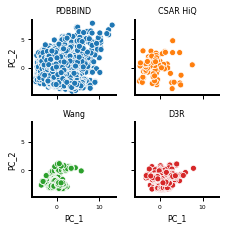

In [32]:
with plt.style.context(style_base):

    ax = sns.relplot(data=grouped_y_dists[["DS", "PC_1", "PC_2"]], x="PC_1", y="PC_2", col="DS", hue="DS", 
                     col_wrap=2, col_order=relevant_grps,
                     hue_order=relevant_grps, legend=False)
    fig = ax.fig
    ax.set_titles("{col_name}")
    fig.set_size_inches((3.3,3.3))
    fig.savefig(os.path.join(datadir, "plots", "feature_pca_comp.svg"))
    fig.savefig(os.path.join(datadir, "plots", "feature_pca_comp.png"))

In [33]:
pdbbind_by_pc = grouped_y_dists.query('DS == "PDBBIND"').melt(id_vars=cols[:-n_PCs], value_vars=cols[-n_PCs:], var_name="PC")


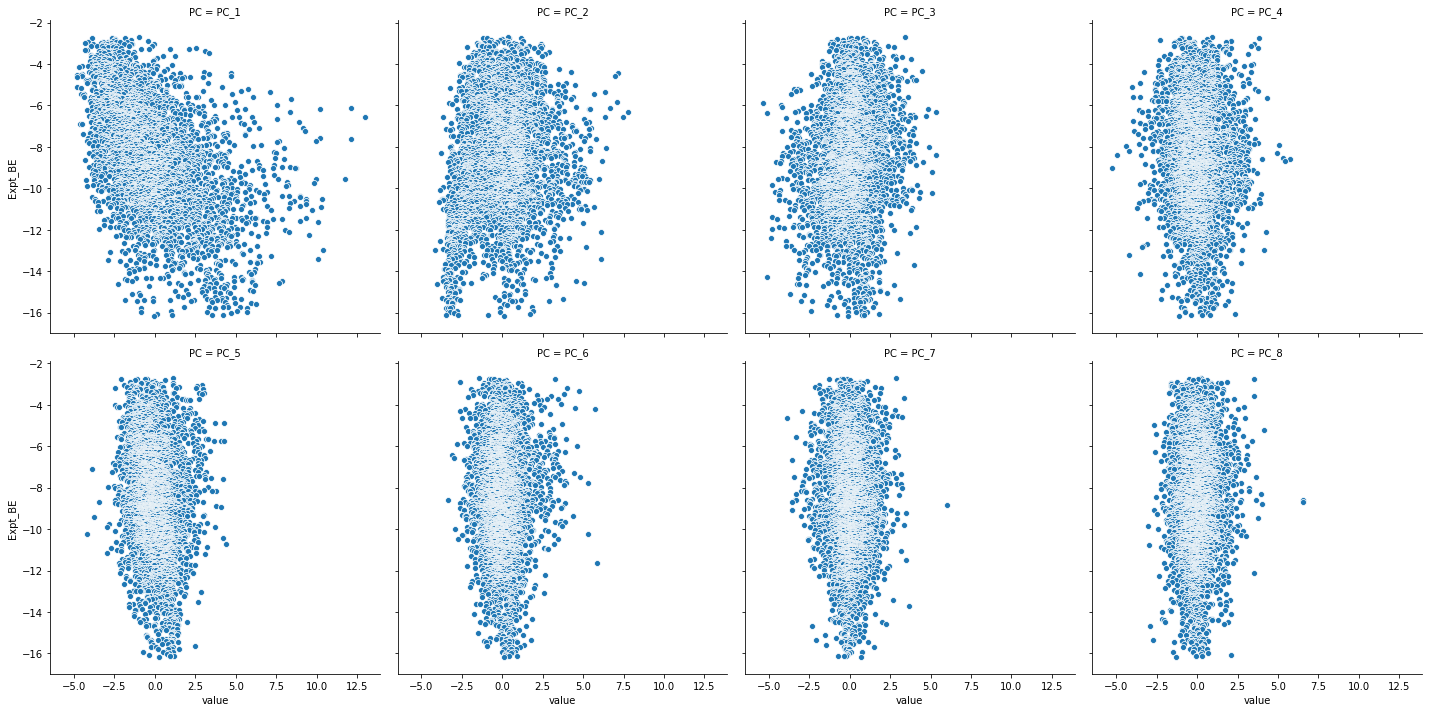

In [34]:
sns.relplot(data=pdbbind_by_pc, x="value", y="Expt_BE", col="PC", col_wrap=4)
plt.tight_layout()

In [35]:
pdbbind_by_pc.groupby("PC")[["value", "Expt_BE"]].corr().iloc[0::2,-1].to_frame()

,,Expt_BE
PC,,
PC_1,value,-0.470585
PC_2,value,0.174619
PC_3,value,0.143655
PC_4,value,-0.031689
PC_5,value,-0.156467
PC_6,value,0.002592
PC_7,value,-0.011587
PC_8,value,0.036424
